In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'brk'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0493103446445398 	 Validation loss: 1.9974822250463196 	 
  1%|          | 574/57400 [01:38<2:43:24,  5.80it/s]
Epoch 2 	 Training loss: 1.9920722138175566 	 Validation loss: 1.981296131166361 	 
  2%|▏         | 1148/57400 [03:18<2:16:24,  6.87it/s]
Epoch 3 	 Training loss: 1.9856174883111428 	 Validation loss: 1.9699206473463673 	 
  3%|▎         | 1722/57400 [04:58<2:41:25,  5.75it/s]
Epoch 4 	 Training loss: 1.9776090690898562 	 Validation loss: 1.9731337923114582 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:38<2:15:37,  6.77it/s]
Epoch 5 	 Training loss: 1.9727402055305057 	 Validation loss: 1.9703322709616968 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:17<2:23:32,  6.33it/s]
Epoch 6 	 Training loss: 1.9688049174767337 	 Validation loss: 1.9722705210669567 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:58<2:47:35,  5.37it/s]
Epoch 7 	 Training loss: 1.9660295478558292 	 Validation loss: 1.9696202965

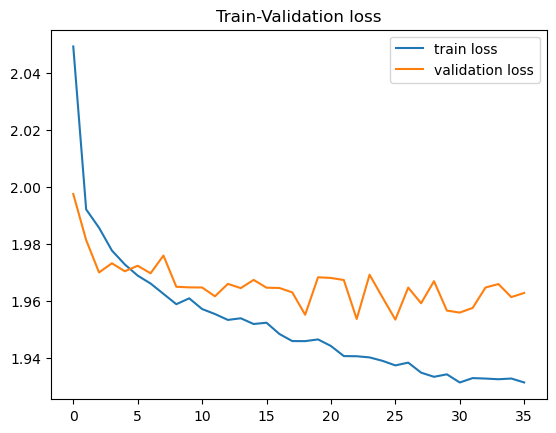

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_brk_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7171717171717171, 'precision': 0.7171717171717171, 'f1': 0.7171717171717171, 'accuracy': 0.7171717171717171}, 'as': {'recall': 0.7222946544980443, 'precision': 0.7222946544980443, 'f1': 0.7222946544980443, 'accuracy': 0.7222946544980443}, 'about': {'recall': 0.8507653061224489, 'precision': 0.8507653061224489, 'f1': 0.8507653061224489, 'accuracy': 0.8507653061224489}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7445255474452555, 'precision': 0.7445255474452555, 'f1': 0.7445255474452555, 'accuracy': 0.7445255474452555}, 'as': {'recall': 0.75, 'precision': 0.75, 'f1': 0.75, 'accuracy': 0.75}, 'about': {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506}, 'as': {'recall': 0.692722371967655, 'precision': 0.6927223

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0589122205245785 	 Validation loss: 2.008188084020453 	 
  1%|          | 574/57400 [01:36<2:28:44,  6.37it/s]
Epoch 2 	 Training loss: 1.9944924321739517 	 Validation loss: 1.9830077583506955 	 
  2%|▏         | 1148/57400 [03:14<2:26:10,  6.41it/s]
Epoch 3 	 Training loss: 1.9825221131902955 	 Validation loss: 1.9900726625474834 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:50<2:24:59,  6.40it/s]
Epoch 4 	 Training loss: 1.9787951388010165 	 Validation loss: 1.9743511414123793 	 
  4%|▍         | 2296/57400 [06:27<2:27:17,  6.24it/s]
Epoch 5 	 Training loss: 1.9729408366339547 	 Validation loss: 1.9742644520129187 	 
  5%|▌         | 2870/57400 [08:04<2:21:23,  6.43it/s]
Epoch 6 	 Training loss: 1.969811030173551 	 Validation loss: 1.9699641829830106 	 
  6%|▌         | 3444/57400 [09:41<2:17:48,  6.53it/s]
Epoch 7 	 Training loss: 1.9659644840901738 	 Validation loss: 1.9683747352179835 	 
  7%|▋         | 4018/57400 [11:19<2:26:21,  6.08

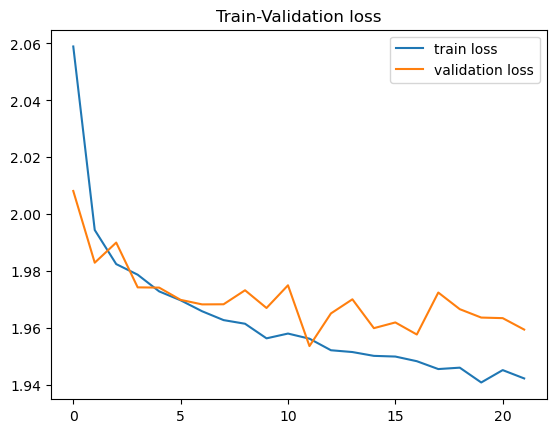

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_brk_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7234848484848485, 'precision': 0.7234848484848485, 'f1': 0.7234848484848485, 'accuracy': 0.7234848484848485}, 'as': {'recall': 0.7353324641460235, 'precision': 0.7353324641460235, 'f1': 0.7353324641460234, 'accuracy': 0.7353324641460235}, 'about': {'recall': 0.8329081632653061, 'precision': 0.8329081632653061, 'f1': 0.8329081632653061, 'accuracy': 0.8329081632653061}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7449494949494949, 'precision': 0.7449494949494949, 'f1': 0.7449494949494948, 'accuracy': 0.7449494949494949}, 'about': {'recall': 0.8463541666666666, 'precision': 0.8463541666666666, 'f1': 0.8463541666666666, 'accuracy': 0.8463541666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346}, 'a

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.056660860465379 	 Validation loss: 1.9916214478217948 	 
  1%|          | 574/57400 [01:37<2:43:12,  5.80it/s]
Epoch 2 	 Training loss: 1.9904094822315388 	 Validation loss: 1.9871715771949898 	 
  2%|▏         | 1148/57400 [03:15<2:28:50,  6.30it/s]
Epoch 3 	 Training loss: 1.9787494708436706 	 Validation loss: 1.9780403456445468 	 
  3%|▎         | 1722/57400 [04:52<2:37:15,  5.90it/s]
Epoch 4 	 Training loss: 1.9738073382228094 	 Validation loss: 1.9743553177785065 	 
  4%|▍         | 2296/57400 [06:28<2:19:22,  6.59it/s]
Epoch 5 	 Training loss: 1.9714429930942814 	 Validation loss: 1.9696735891245178 	 
  5%|▌         | 2870/57400 [08:05<2:12:43,  6.85it/s]
Epoch 6 	 Training loss: 1.969180274300459 	 Validation loss: 1.9703383728609247 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:42<2:23:15,  6.28it/s]
Epoch 7 	 Training loss: 1.964894138146776 	 Validation loss: 1.9659920425738318 	 
  7%|▋         | 4018/57400 [11:19<2:43:25,  5.44i

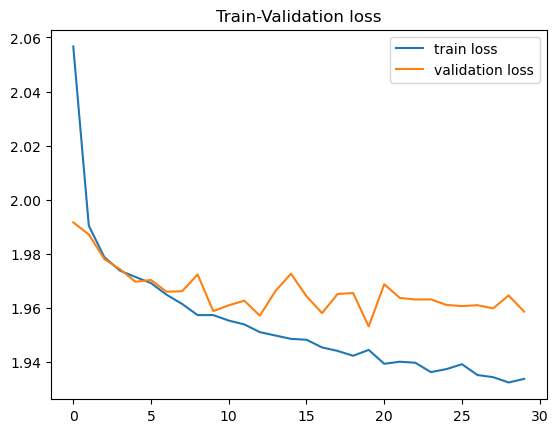

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_brk_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7209595959595959, 'precision': 0.7209595959595959, 'f1': 0.7209595959595958, 'accuracy': 0.7209595959595959}, 'as': {'recall': 0.7314211212516297, 'precision': 0.7314211212516297, 'f1': 0.7314211212516297, 'accuracy': 0.7314211212516297}, 'about': {'recall': 0.8520408163265306, 'precision': 0.8520408163265306, 'f1': 0.8520408163265306, 'accuracy': 0.8520408163265306}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7299270072992701, 'precision': 0.7299270072992701, 'f1': 0.72992700729927, 'accuracy': 0.7299270072992701}, 'as': {'recall': 0.7449494949494949, 'precision': 0.7449494949494949, 'f1': 0.7449494949494948, 'accuracy': 0.7449494949494949}, 'about': {'recall': 0.8463541666666666, 'precision': 0.8463541666666666, 'f1': 0.8463541666666666, 'accuracy': 0.8463541666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7112860892388452, 'precision': 0.7112860892388452, 'f1': 0.7112860892388452, 'accuracy': 0.7112860892388452}, 'as'

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8452380952380952, 'precision': 0.8452380952380952, 'f1': 0.8452380952380952, 'accuracy': 0.8452380952380952}
Métricas etiqueta male: {'recall': 0.8498263888888888, 'precision': 0.8498263888888888, 'f1': 0.8498263888888888, 'accuracy': 0.8498263888888888}
Métricas etiqueta female:  {'recall': 0.8408333333333333, 'precision': 0.8408333333333333, 'f1': 0.8408333333333333, 'accuracy': 0.8408333333333333}

 to
Resultado global: {'recall': 0.7205387205387205, 'precision': 0.7205387205387205, 'f1': 0.7205387205387205, 'accuracy': 0.7205387205387205}
Métricas etiqueta male: {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}
Métricas etiqueta female:  {'recall': 0.7025371828521435, 'precision': 0.7025371828521435, 'f1': 0.7025371828521435, 'accuracy': 0.7025371828521435}

 as
Resultado global: {'recall': 0.7296827466318991, 'precision': 0.7296827466318991, 'f1': 0.7